先从初始训练集训练出一个基学习器,再根据基学习器的表现对训练样本分布进行调整,使得先前基学习器做错的训练样本在后续受到更多关注.

如此重复进行,直至基学习器数目达到事先指定的值$T$,最终将这个$T$个基学习器进行加权结合.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import sys
import warnings

warnings.simplefilter('ignore')

In [2]:
cancer = load_breast_cancer()
X, y = cancer.data,cancer.target
y[y==0]=-1

In [3]:
def load_data():
    cancer = load_breast_cancer()
    return cancer.data,cancer.target

In [4]:
def score(y,y_pred):
    return np.sum(y==y_pred)/len(y)

In [5]:
def expLoss(y,y_pred):
    '''
    y_pred = H(x)
    '''
    n = len(y)
    y_exp = np.exp(-y*y_pred)
    sum_y_exp = np.sum(y_exp)
    return sum_y_exp / n

# 指数函数最小化,则分类错误率也将最小化.

#print(y_0)    
# 将所有0变成1
#for i in range(len(y)):
    #loss = expLoss(y,y_pred)
    #losses.append(loss)

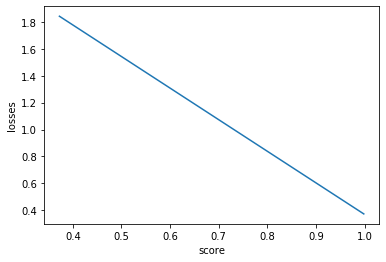

In [6]:
losses = []
y_pred = []
# 将所有1变成-1
y_0 = y.copy()
while np.sum(y_0==1) > 0:
    _, indexs = np.unique(y_0,return_index=True)
    y_0[indexs[1]] = -1
    y_pred.append(score(y,y_0))
    losses.append(expLoss(y,y_0))
    
plt.clf()
plt.plot(y_pred,losses)
plt.xlabel('score')
plt.ylabel('losses')
plt.show()

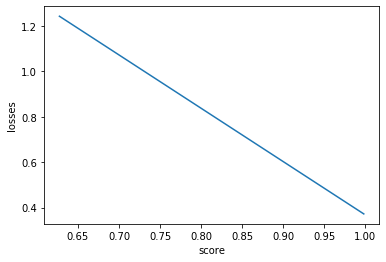

what the fuck


In [7]:
losses = []
y_pred = []
# 将所有0变成1
y_1 = y.copy()
while np.sum(y_1 == -1) > 0:
    _, indexs = np.unique(y_1,return_index=True)
    y_1[indexs[0]] = 1
    y_pred.append(score(y,y_1))
    losses.append(expLoss(y,y_1))

plt.clf()
plt.plot(y_pred,losses)
plt.xlabel('score')
plt.ylabel('losses')
plt.show()
print('what the fuck')

In [8]:
def flip_coin(y):
    n = len(y)
    return np.random.randint(0,2,size=n)

In [9]:
X_train,X_test,y_train,y_test = train_test_split(X,y)
ras= np.random.randint(2**32 - 1)
print(ras)
clf = DecisionTreeClassifier(max_depth=1,max_features=1,splitter='random',random_state=ras)
clf.fit(X_train,y_train)
print(clf.score(X_test,y_test))
print(clf)

3923743676
0.6993006993006993
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
                       max_features=1, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=3923743676, splitter='random')


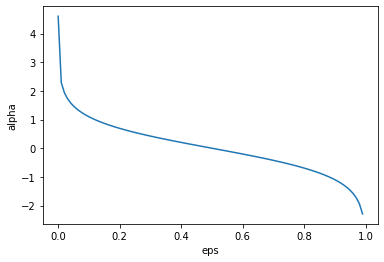

In [10]:
def plot_alpha():
    eps = np.linspace(1e-4,1.,100)
    alpha = np.log((1-eps)/eps) / 2.
    plt.clf()
    plt.plot(eps, alpha)
    plt.xlabel('eps')
    plt.ylabel('alpha')
    plt.show()
plot_alpha()
# eps越大alpha越小,且当

In [11]:
def epsilon(y_true,y_pred, W):
    '''
    计算误差率
    '''
    return np.sum(W[y_true!=y_pred])

clf = DecisionTreeClassifier(max_depth=1,max_features=1,splitter='random',random_state=ras)
clf.fit(X_train,y_train)
W = np.full(X_train.shape[0],1/len(y_train))
print(1-epsilon(y_train,clf.predict(X_train), W))
print(clf.score(X_train,y_train))

0.6971830985915494
0.6971830985915493


In [12]:
class AdaboossClf:
    
    def __init__(self,T = 25):
        '''
        @param T 几个迭代器
        '''
        self.T = T
        self.alphas_ = None
        self.weak_estimators_ = None
        self.weak_score_ = None
        self.e_ = None
        
    def epsilon(self,y_true,y_pred, W):
        '''
        计算误差率
        '''
        return np.sum(W[y_true!=y_pred])

    def trimY(self,y):
        '''
        把所有的y==0置成-1
        '''
        y[y==0] = -1
        
    def fit(self,X_train,y_train):
        self.trimY(y_train)
        self.alphas_ = []
        self.weak_estimators_ = []
        self.weak_score_ = []
        self.e_ = []
        n = len(y_train)
        W = np.full(n, 1./n)

        # T次训练
        for t in range(self.T) :
            rnd_seed = np.random.randint(2**32 - 1)
            # 有随机性的弱分类器...
            we_clf = DecisionTreeClassifier(
                max_depth=1
                ,max_features=1
                ,splitter='random'
                ,random_state=rnd_seed
            )
            # 训练弱分类器
            we_clf.fit(X_train,y_train)
            y_predict = we_clf.predict(X_train)
            # 计算错误分类率
            e_we = self.epsilon(y_train, y_predict, W)
            # Todo 
            #if (e_we > 0.5):
            #    print('e so weak : ', e_we)
            #    break
            # 分类器权重更新
            # 此为对弱分类器的指数函数分类期望求导=0后所得,分类器权重更新公式.
            alpha = np.log((1 - e_we) / e_we) / 2.
            # 做个记录.
            self.e_.append(e_we)
            self.weak_score_.append(we_clf.score(X_train,y_train))
            self.weak_estimators_.append(we_clf)
            self.alphas_.append(alpha)
            # 下一轮的学习能够纠正Ht-1的错误
            # 更新W
            Z = np.sum(W * np.exp(-alpha * y_train * y_predict))
            W = (W / Z) * np.exp(-alpha * y_train * y_predict)
        return self
    
    def predict(self,X_test,y_test):
        # 短路
        if self.weak_estimators_ is None:
            print('fit it first')
            return
        self.trimY(y_test)
        y_res = np.zeros(y_test.shape)
        for clf, alpha in zip(self.weak_estimators_,self.alphas_):
            y_p = clf.predict(X_test)
            y_res += alpha * y_p
        return np.sign(y_res)
    
    def score(self,X_test,y_test):
        y_p = self.predict(X_test,y_test)
        return self.metric_score(y_test, y_p)
    
    def metric_score(self,y_true, y_p):
        return np.sum(y_true == y_p) / len(y_true)

ensemble_score :  0.8531468531468531
weak mean score :  0.6913752913752912


<Figure size 432x288 with 0 Axes>

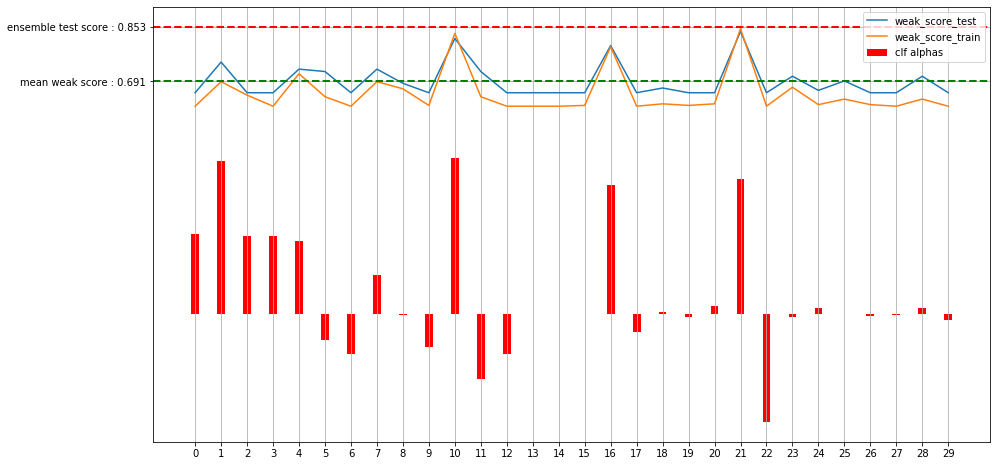

In [28]:
def visual_result(X,y):
    # 学习器数量
    T = 30
    idxs = np.arange(0, T, 1)
    X_train,X_test,y_train,y_test = train_test_split(X,y)
    clf = AdaboossClf(T=T).fit(X_train,y_train)
    # 非常有必要
    clf.trimY(y_train)
    clf.trimY(y_test)
    # 集成学习分数
    ensemble_score = clf.score(X_test,y_test)
    # 弱学习器分数
    weak_clfs = clf.weak_estimators_
    weak_clfs_alphas = clf.alphas_
    weak_score_train = clf.weak_score_
    
    weak_score_test = []
    y_ticks = []
    y_ticks_labels = []
    y_ticks.append(ensemble_score)
    y_ticks_labels.append('ensemble test score : {}'.format(round(ensemble_score,3)))
    for i in idxs:
        y_p = weak_clfs[i].predict(X_test)
        w_s_t = clf.metric_score(y_test,y_p)
        weak_score_test.append(w_s_t)
        w_s_te = 'test_score: {}'.format(round(w_s_t,3))
        w_s_tr = 'train_score: {}'.format(round(weak_score_train[i],3))
        #y_ticks.append(w_s_t)
        #y_ticks.append(weak_score_train[i])
        #y_ticks_labels.append(w_s_te)
        #y_ticks_labels.append(w_s_tr)
    
    mean_weak_score_test = np.mean(weak_score_test)
    y_ticks.append(mean_weak_score_test)
    y_ticks_labels.append('mean weak score : {}'.format(round(mean_weak_score_test,3)))
    print('ensemble_score : ', ensemble_score)
    print('weak mean score : ', mean_weak_score_test)
    plt.clf()
    fig = plt.figure(figsize=(15,8))
    plt.plot(idxs,weak_score_test,label='weak_score_test')
    plt.plot(idxs,weak_score_train,label='weak_score_train')
    plt.bar(idxs,weak_clfs_alphas,label='clf alphas',width=0.3,color='r')
    ax = plt.gca()
    xlim = ax.get_xlim()
    x_range = np.linspace(xlim[0],xlim[1],100)
    ax.set_xlim(xlim)
    #ax.set_ylim()
    ax.set_xticks(idxs)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_ticks_labels,rotation=0)
    ax.grid(True)
    plt.plot(x_range, np.full(x_range.shape,ensemble_score),color='r',linewidth=2,linestyle='--')
    plt.plot(x_range, np.full(x_range.shape,mean_weak_score_test),color='g',linewidth=2,linestyle='--')

    plt.legend(loc='upper right')
    #fig.tight_layout()
    plt.show()
    
X,y = load_data()
visual_result(X,y)

In [14]:
def epsilon(y_true,y_pred, W):
    '''
    计算误差率
    '''
    return np.sum(W[y_true!=y_pred])

In [15]:
X_f = np.arange(0,10,1)
y = np.array([1,1,1,-1,-1, -1, 1, 1, 1, -1])
def G1(X_G):
    res = np.ones(len(X_G))
    res[X_G>2.5]=-1
    return res
def G2(X_G):
    res = np.ones(len(X_G))
    res[X_G>8.5]=-1
    return res
#print('score : ',np.sum(G(X_f)==y)/len(X_f))
W = np.full(10,0.1)
e = epsilon(y,G1(X_f),W)
alpha = np.log((1-e)/e)/2.
Z = np.sum(W * np.exp(-alpha * y * G1(X_f)))
W = (W / Z) * np.exp(-alpha * y * G1(X_f))
clf = AdaboossClf().fit(X_f.reshape(-1,1),y)
clf.score(X_f.reshape(-1,1),y)
print(e)
print(W)
print(alpha)
#clf.alphas_
#np.exp(-alpha*)

0.30000000000000004
[0.07142857 0.07142857 0.07142857 0.07142857 0.07142857 0.07142857
 0.16666667 0.16666667 0.16666667 0.07142857]
0.4236489301936017


In [16]:
e = epsilon(y,G2(X_f),W)
alpha = np.log((1-e)/e)/2.
Z = np.sum(W * np.exp(-alpha * y * G2(X_f)))
W = (W / Z) * np.exp(-alpha * y * G2(X_f))
print(e)
print(W)
print(alpha)

#clf = AdaboossClf().fit(X_f.reshape(-1,1),y)
#clf.score(X_f.reshape(-1,1),y)

0.21428571428571427
[0.04545455 0.04545455 0.04545455 0.16666667 0.16666667 0.16666667
 0.10606061 0.10606061 0.10606061 0.04545455]
0.6496414920651304
